### SAT scores and demographics
* Correlate SAT scores with factors like race, sex, income and more
* Dataset: New York City data on high school SAT scores, demographics for each hight school

#### What we want to research:
* New York City
* The SAT
* Schools in NYC
* Data

####  What we can learn
* Only high school students take the SAT, wo we'll want to focus on high school
* NYC is made up of five boroughs, which are essentially distinct regions
* NYC schools fall within several different school districts, each of which can contains dozens of schools
* The data sets include several different types of schools. We'll need to clean them so that we can focus on high school only.
* Each school in NYC has a unique code called a DBN, or district borough number
* Aggregating data by district will allow us to use the district mapping data to plot district-by-district differences.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
data_files = ["ap_2010.csv", "class_size.csv", 'demographics.csv', 'graduation.csv',
             'hs_directory.csv', 'sat_results.csv']
data = {}
for d in data_files:
    key = d.split('.')[0]
    data[key] = pd.read_csv('schools/{}'.format(d))

In [3]:
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


* DBN a unique ID for each school
* From the first few rows of names that we only have data about high schools
* There's only a single row for each high school, so each DBN is unique in he SAT data
* May want to combine the columns that contain SAT scores -- SAT Critical REading... in to a single column

In [4]:
data['sat_results'].corr()

""


In [5]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


* Each dataset appears to have a DBN column, or the information needed to create one.
* Some of the datasets appear to contain multiple row s for each school

In [6]:
data['class_size'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27611 entries, 0 to 27610
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   CSD                                   27611 non-null  int64  
 1   BOROUGH                               27611 non-null  object 
 2   SCHOOL CODE                           27611 non-null  object 
 3   SCHOOL NAME                           27611 non-null  object 
 4   GRADE                                 26127 non-null  object 
 5   PROGRAM TYPE                          26127 non-null  object 
 6   CORE SUBJECT (MS CORE and 9-12 ONLY)  26127 non-null  object 
 7   CORE COURSE (MS CORE and 9-12 ONLY)   26127 non-null  object 
 8   SERVICE CATEGORY(K-9* ONLY)           26127 non-null  object 
 9   NUMBER OF STUDENTS / SEATS FILLED     26127 non-null  float64
 10  NUMBER OF SECTIONS                    26127 non-null  float64
 11  AVERAGE CLASS S

In [7]:
all_survey = pd.read_csv('schools/survey_all.txt', delimiter='\t', encoding="windows-1252")
d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter='\t', encoding = 'windows-1252')
survey = pd.concat([all_survey, d75_survey], axis = 0)
survey.head()

,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,0,Yes,0.0,Elementary / Middle School,89.0,73,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,M063,P.S. 063 William McKinley,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
survey.shape

(1702, 2773)

In [9]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1702 entries, 0 to 55
Columns: 2773 entries, dbn to s_q14_11
dtypes: float64(2762), int64(6), object(5)
memory usage: 36.0+ MB


* There are over 2000 columns, nearly all of which we don't need. Have to filter the data to remove unnecessary ones
* The survey contains a dbn column

In [10]:
survey['DBN'] = survey['dbn']
survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", 
                   "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", 
                   "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
survey = survey[survey_fields]
data['survey'] = survey
data['survey'].shape

(1702, 23)

In [11]:
survey.head()

,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,7.6,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,8.9,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,6.8,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,...,6.8,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,...,7.8,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0


In [12]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


In [13]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn']
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(lambda x:'0'+str(x) if 
                                                                   len(str(x)) < 2 else str(x))
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


In [14]:
data['sat_results'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   DBN                              478 non-null    object
 1   SCHOOL NAME                      478 non-null    object
 2   Num of SAT Test Takers           478 non-null    object
 3   SAT Critical Reading Avg. Score  478 non-null    object
 4   SAT Math Avg. Score              478 non-null    object
 5   SAT Writing Avg. Score           478 non-null    object
dtypes: object(6)
memory usage: 22.5+ KB


* pandas.to_numeric()
* errors="coerce", so that pandas treats any invalid strings it can't convert to numbers as missing values instead

In [15]:
sat_cols = ["SAT Math Avg. Score", "SAT Critical Reading Avg. Score", "SAT Writing Avg. Score"]
for col in sat_cols:
    data['sat_results'][col] = pd.to_numeric(data['sat_results'][col], errors = 'coerce')
data['sat_results']['sat_score'] = (data['sat_results']["SAT Math Avg. Score"] + 
                                    data['sat_results']["SAT Critical Reading Avg. Score"]+
                                   data['sat_results']["SAT Writing Avg. Score"])
data['sat_results']['sat_score'].head()
# Seems result different from df.sum(axis = 1)

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64

In [16]:
data['hs_directory'].head()

,dbn,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority09,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,DBN
0,21K540,John Dewey High School,Brooklyn,K540,718-373-6400,718-266-4385,9.0,12,NaN,NaN,...,NaN,NaN,"50 Avenue\nX Brooklyn, NY 11223\n(40.589238098...",13.0,47.0,308.0,3194998.0,3.071850e+09,Gravesend ...,21K540
1,15K429,Brooklyn School for Global Studies,Brooklyn,K293,718-694-9741,718-694-9745,6.0,12,NaN,NaN,...,NaN,NaN,"284 Baltic Street\nBrooklyn, NY 11201\n(40.685...",6.0,33.0,69.0,3006401.0,3.004020e+09,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hi...,15K429
2,24Q530,International High School at LaGuardia Communi...,Queens,Q520,718-392-3433,718-392-3443,9.0,12,NaN,NaN,...,NaN,NaN,"45 35 Van Dam Street\nLong Island City, NY 111...",2.0,26.0,179.0,4003442.0,4.002490e+09,Hunters Point-Sunnyside-West Maspeth ...,24Q530
3,05M367,Academy for Social Action: A College Board School,Manhattan,M043,212-234-3102,212-234-8597,9.0,12,NaN,NaN,...,NaN,NaN,"509 West 129 Street\nNew York, NY 10027\n(40.8...",9.0,7.0,219.0,1059723.0,1.019840e+09,Manhattanville ...,05M367
4,27Q260,Frederick Douglass Academy VI High School,Queens,Q465,718-471-2154,718-471-2890,9.0,12,NaN,NaN,...,NaN,NaN,"8 21 Bay 25 Street\nFar Rockaway, NY 11691\n(4...",14.0,31.0,100802.0,4300730.0,4.157360e+09,Far Rockaway-Bayswater ...,27Q260


* Parse the latitude and longitude coordinates for each school.
* Coordinates are in the text field Location 1

In [17]:
data['hs_directory']['Location 1'].head()

0    50 Avenue\nX Brooklyn, NY 11223\n(40.589238098...
1    284 Baltic Street\nBrooklyn, NY 11201\n(40.685...
2    45 35 Van Dam Street\nLong Island City, NY 111...
3    509 West 129 Street\nNew York, NY 10027\n(40.8...
4    8 21 Bay 25 Street\nFar Rockaway, NY 11691\n(4...
Name: Location 1, dtype: object

In [18]:
def extract_latitude(string):
    content = re.findall(r"\(.+\)", string)
    return content[0].split('(')[-1].split(',')[0]
data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(extract_latitude)
data['hs_directory'].head()

,dbn,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,DBN,lat
0,21K540,John Dewey High School,Brooklyn,K540,718-373-6400,718-266-4385,9.0,12,NaN,NaN,...,NaN,"50 Avenue\nX Brooklyn, NY 11223\n(40.589238098...",13.0,47.0,308.0,3194998.0,3.071850e+09,Gravesend ...,21K540,40.589238098
1,15K429,Brooklyn School for Global Studies,Brooklyn,K293,718-694-9741,718-694-9745,6.0,12,NaN,NaN,...,NaN,"284 Baltic Street\nBrooklyn, NY 11201\n(40.685...",6.0,33.0,69.0,3006401.0,3.004020e+09,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hi...,15K429,40.685451806
2,24Q530,International High School at LaGuardia Communi...,Queens,Q520,718-392-3433,718-392-3443,9.0,12,NaN,NaN,...,NaN,"45 35 Van Dam Street\nLong Island City, NY 111...",2.0,26.0,179.0,4003442.0,4.002490e+09,Hunters Point-Sunnyside-West Maspeth ...,24Q530,40.744149536
3,05M367,Academy for Social Action: A College Board School,Manhattan,M043,212-234-3102,212-234-8597,9.0,12,NaN,NaN,...,NaN,"509 West 129 Street\nNew York, NY 10027\n(40.8...",9.0,7.0,219.0,1059723.0,1.019840e+09,Manhattanville ...,05M367,40.815230365
4,27Q260,Frederick Douglass Academy VI High School,Queens,Q465,718-471-2154,718-471-2890,9.0,12,NaN,NaN,...,NaN,"8 21 Bay 25 Street\nFar Rockaway, NY 11691\n(4...",14.0,31.0,100802.0,4300730.0,4.157360e+09,Far Rockaway-Bayswater ...,27Q260,40.601989336


In [19]:
def extract_longitude(string):
    content = re.findall(r"\(.+\)", string)
    return content[0].split(')')[0].split(',')[-1]
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(extract_longitude)
data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors = 'coerce')
data['hs_directory'].head()

,dbn,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,DBN,lat,lon
0,21K540,John Dewey High School,Brooklyn,K540,718-373-6400,718-266-4385,9.0,12,NaN,NaN,...,"50 Avenue\nX Brooklyn, NY 11223\n(40.589238098...",13.0,47.0,308.0,3194998.0,3.071850e+09,Gravesend ...,21K540,40.589238,-73.981747
1,15K429,Brooklyn School for Global Studies,Brooklyn,K293,718-694-9741,718-694-9745,6.0,12,NaN,NaN,...,"284 Baltic Street\nBrooklyn, NY 11201\n(40.685...",6.0,33.0,69.0,3006401.0,3.004020e+09,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hi...,15K429,40.685452,-73.993491
2,24Q530,International High School at LaGuardia Communi...,Queens,Q520,718-392-3433,718-392-3443,9.0,12,NaN,NaN,...,"45 35 Van Dam Street\nLong Island City, NY 111...",2.0,26.0,179.0,4003442.0,4.002490e+09,Hunters Point-Sunnyside-West Maspeth ...,24Q530,40.744150,-73.933627
3,05M367,Academy for Social Action: A College Board School,Manhattan,M043,212-234-3102,212-234-8597,9.0,12,NaN,NaN,...,"509 West 129 Street\nNew York, NY 10027\n(40.8...",9.0,7.0,219.0,1059723.0,1.019840e+09,Manhattanville ...,05M367,40.815230,-73.955201
4,27Q260,Frederick Douglass Academy VI High School,Queens,Q465,718-471-2154,718-471-2890,9.0,12,NaN,NaN,...,"8 21 Bay 25 Street\nFar Rockaway, NY 11691\n(4...",14.0,31.0,100802.0,4300730.0,4.157360e+09,Far Rockaway-Bayswater ...,27Q260,40.601989,-73.762834


#### Combining the data
* Clean the data a bit more, then combine it.
* Comoute correlations and perform some analysis
* Have to condense the class_siz, graduation and demographics data sets so that each DBN is unique

In [20]:
for key in data.keys():
    print('DBN' in data[key].columns)

True
True
True
True
True
True
True


In [21]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


In [22]:
data['class_size'].columns = data['class_size'].columns.str.strip()

In [23]:
data['class_size'].GRADE.unique()
# High school 9-12

array(['0K', '01', '02', '03', '04', '05', '0K-09', nan, '06', '07', '08',
       'MS Core', '09-12', '09'], dtype=object)

In [24]:
data['class_size']['PROGRAM TYPE'].value_counts()

GEN ED     14545
CTT         7460
SPEC ED     3653
G&T          469
Name: PROGRAM TYPE, dtype: int64

In [25]:
class_size = data["class_size"]
class_size = class_size.loc[class_size['GRADE'] == '09-12'].loc[class_size['PROGRAM TYPE'] == 'GEN ED']
class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


In [26]:
class_size['GRADE'].value_counts()

09-12    6513
Name: GRADE, dtype: int64

In [27]:
class_size["CORE SUBJECT (MS CORE and 9-12 ONLY)"].value_counts()

ENGLISH           1977
SCIENCE           1636
SOCIAL STUDIES    1453
MATH              1447
Name: CORE SUBJECT (MS CORE and 9-12 ONLY), dtype: int64

* Groupby
* Find the column that prevent given DBN from unique

In [28]:
class_size = class_size.groupby('DBN').agg(np.mean)
class_size.reset_index(inplace=True)
data['class_size'] = class_size
data['class_size'].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


In [29]:
class_size.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   DBN                                583 non-null    object 
 1   CSD                                583 non-null    int64  
 2   NUMBER OF STUDENTS / SEATS FILLED  583 non-null    float64
 3   NUMBER OF SECTIONS                 583 non-null    float64
 4   AVERAGE CLASS SIZE                 583 non-null    float64
 5   SIZE OF SMALLEST CLASS             583 non-null    float64
 6   SIZE OF LARGEST CLASS              583 non-null    float64
 7   SCHOOLWIDE PUPIL-TEACHER RATIO     0 non-null      float64
dtypes: float64(6), int64(1), object(1)
memory usage: 36.6+ KB


In [30]:
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In [31]:
data['demographics'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10075 entries, 0 to 10074
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DBN                10075 non-null  object 
 1   Name               10075 non-null  object 
 2   schoolyear         10075 non-null  int64  
 3   fl_percent         8560 non-null   object 
 4   frl_percent        4482 non-null   float64
 5   total_enrollment   10075 non-null  int64  
 6   prek               4712 non-null   object 
 7   k                  5882 non-null   object 
 8   grade1             5881 non-null   object 
 9   grade2             5851 non-null   object 
 10  grade3             5779 non-null   object 
 11  grade4             5741 non-null   object 
 12  grade5             5777 non-null   object 
 13  grade6             4517 non-null   object 
 14  grade7             4203 non-null   object 
 15  grade8             4085 non-null   object 
 16  grade9             397

In [32]:
# The only column that prevents a given DBN from being unique is schoolyear
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

In [33]:
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


In [34]:
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,NaN,s,NaN,NaN,...,s,NaN,NaN,s,NaN,NaN,s,NaN,s,NaN
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3,17,30.9,45.9,...,17,30.9,45.9,20,36.4,54.1,15,27.3,3,5.5
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2,27,42.2,62.8,...,27,42.2,62.8,16,25.0,37.2,9,14.1,9,14.1
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4,37,47.4,84.1,...,37,47.4,84.1,7,9.0,15.9,15,19.2,11,14.1


In [35]:
data['graduation'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25096 entries, 0 to 25095
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Demographic                         25096 non-null  object 
 1   DBN                                 25096 non-null  object 
 2   School Name                         25096 non-null  object 
 3   Cohort                              25096 non-null  object 
 4   Total Cohort                        25096 non-null  int64  
 5   Total Grads - n                     25096 non-null  object 
 6   Total Grads - % of cohort           16704 non-null  float64
 7   Total Regents - n                   25096 non-null  object 
 8   Total Regents - % of cohort         16704 non-null  float64
 9   Total Regents - % of grads          16652 non-null  float64
 10  Advanced Regents - n                25096 non-null  object 
 11  Advanced Regents - % of cohort      16704

In [36]:
# Pick data from the most recent Cohort available 2006. Also want data from the full cohort, pick rows where 
# Demographic is Total Cohort
data['graduation'] = data['graduation'][(data['graduation'].Cohort == '2006') & 
                                       (data['graduation'].Demographic == 'Total Cohort')]
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7,42,33.9,79.2,...,34,27.4,64.2,11,8.9,20.8,46,37.1,20,16.1
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8,67,74.4,95.7,...,67,74.4,95.7,3,3.3,4.3,15,16.7,5,5.6
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56.0,40,47.6,85.1,...,23,27.4,48.9,7,8.3,14.9,25,29.8,5,6.0
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4,91,47.2,86.7,...,22,11.4,21.0,14,7.3,13.3,53,27.5,35,18.1


* Convert the Advanced Placement (AP) test scores from strings to numeric values.

In [37]:
data['ap_2010'].dtypes

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object

In [38]:
ap_cols = data['ap_2010'].columns.to_list()[-3:]
for col in ap_cols:
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors='coerce')
data['ap_2010'].dtypes

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object

* Merge data
* sat_results <-- hs_directory <-- ap_2010 <-- class_size
* left, right, inner, outer
* How to choose a merge strategy

In [39]:
data['graduation'].DBN.isnull().sum()

0

In [40]:
combined = data['sat_results']
combined = pd.merge(combined, data['ap_2010'], how='left', on='DBN')
combined = pd.merge(combined, data['graduation'], how = 'left', on = 'DBN')
combined.head()
combined.shape

(479, 33)

In [41]:
data.keys()

dict_keys(['ap_2010', 'class_size', 'demographics', 'graduation', 'hs_directory', 'sat_results', 'survey'])

In [42]:
keys_for_merge = ['class_size', 'demographics', 'survey', 'hs_directory']
for key in keys_for_merge:
    combined = pd.merge(combined, data[key], on = 'DBN', how = 'inner')
combined.head()
combined.shape

(363, 165)

In [43]:
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,NaN,"200 Monroe Street\nNew York, NY 10002\n(40.712...",3.0,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...,40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",3.0,2.0,34.0,1005974.0,1.004390e+09,East Village ...,40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,NaN,"145 Stanton Street\nNew York, NY 10002\n(40.72...",3.0,1.0,3001.0,1004323.0,1.003540e+09,Chinatown ...,40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,...,NaN,"111 Columbia Street\nNew York, NY 10002\n(40.7...",3.0,2.0,2201.0,1004070.0,1.003350e+09,Lower East Side ...,40.718725,-73.979426


In [44]:
combined[combined.columns[combined.isnull().sum() > 0]].isnull().sum()

SAT Critical Reading Avg. Score     28
SAT Math Avg. Score                 28
SAT Writing Avg. Score              28
sat_score                           28
SchoolName                         135
                                  ... 
Council District                     2
Census Tract                         2
BIN                                  3
BBL                                  3
NTA                                  2
Length: 81, dtype: int64

In [45]:
combined.sat_score.mean()

1223.4388059701494

In [46]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,0.0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0.0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",3.0,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...,40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0.0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",3.0,2.0,34.0,1005974.0,1.004390e+09,East Village ...,40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0.0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",3.0,1.0,3001.0,1004323.0,1.003540e+09,Chinatown ...,40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0.0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",3.0,2.0,2201.0,1004070.0,1.003350e+09,Lower East Side ...,40.718725,-73.979426


In [47]:
df = pd.DataFrame([[np.nan, 2, np.nan, 0],
...                    [3, 4, np.nan, 1],
...                    [np.nan, np.nan, np.nan, 5],
...                    [np.nan, 3, np.nan, 4]],
...                   columns=list('ABCD'))
df

,A,B,C,D
0,NaN,2.0,NaN,0
1,3.0,4.0,NaN,1
2,NaN,NaN,NaN,5
3,NaN,3.0,NaN,4


In [48]:
df = df.fillna(df.mean())
df

,A,B,C,D
0,3.0,2.0,NaN,0
1,3.0,4.0,NaN,1
2,3.0,3.0,NaN,5
3,3.0,3.0,NaN,4


In [49]:
df.apply(lambda x : x.fillna(x.mean()), axis = 0)

,A,B,C,D
0,3.0,2.0,NaN,0
1,3.0,4.0,NaN,1
2,3.0,3.0,NaN,5
3,3.0,3.0,NaN,4


In [50]:
for col in df.columns:
    df[col] = df[col].fillna(df[col].mean())
df

,A,B,C,D
0,3.0,2.0,NaN,0
1,3.0,4.0,NaN,1
2,3.0,3.0,NaN,5
3,3.0,3.0,NaN,4


In [51]:
combined.mean()

SAT Critical Reading Avg. Score    4.041194e+02
SAT Math Avg. Score                4.196567e+02
SAT Writing Avg. Score             3.996627e+02
sat_score                          1.223439e+03
AP Test Takers                     1.290288e+02
                                       ...     
Census Tract                       3.760028e+03
BIN                                2.587480e+06
BBL                                2.515083e+09
lat                                4.074353e+01
lon                               -7.392534e+01
Length: 87, dtype: float64

In [52]:
def extract_two(string):
    return string[:2]
combined['school_dist'] = combined['DBN'].apply(extract_two)
combined.school_dist.head()

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object

In [53]:
combined.DBN.str[:2].head()

0    01
1    01
2    01
3    01
4    01
Name: DBN, dtype: object

In [54]:
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,"200 Monroe Street\nNew York, NY 10002\n(40.712...",3.0,1.0,202.0,1003214.0,1.002590e+09,Lower East Side ...,40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,"420 East 12 Street\nNew York, NY 10009\n(40.72...",3.0,2.0,34.0,1005974.0,1.004390e+09,East Village ...,40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,"145 Stanton Street\nNew York, NY 10002\n(40.72...",3.0,1.0,3001.0,1004323.0,1.003540e+09,Chinatown ...,40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,"111 Columbia Street\nNew York, NY 10002\n(40.7...",3.0,2.0,2201.0,1004070.0,1.003350e+09,Lower East Side ...,40.718725,-73.979426,01


### Analyzing and Visualizing Data

* Discover correlations, creat plots, and make maps.
* Finad any correlations between any of the columns and sta_score.

In [55]:
correlations = combined.corr()
correlations = correlations['sat_score']
correlations

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
Census Tract                       0.048737
BIN                                0.052232
BBL                                0.044427
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 85, dtype: float64

In [56]:
correlations[(correlations > 0.25) | (correlations < -0.25)]

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
Total Grads - % of cohort               0.584234
Total Regents - % of cohort             0.667603
Total Regents - % of grads              0.494732
Advanced Regents - % of cohort          0.771566
Advanced Regents - % of grads           0.739927
Regents w/o Advanced - % of grads      -0.456213
Local - % of cohort                    -0.467951
Local - % of grads                     -0.494732
Still Enrolled - % of cohort           -0.491914
Dropped Out - % of cohort              -0.458537
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE  

* total_enrollment has a strong positive correlation with sta_score. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true -- large schools tend to be better on the SAT.
* Both the percentage of females (female_per) and number of females (female_num) at a school correlate positively with SAT score, whereas the percentage of males (male_per) and the number of males (male_num) correlate nagetively. 
* There is significant racial inequaity in SAT scores (white_per, asian_per, black_per, hispanic_per)


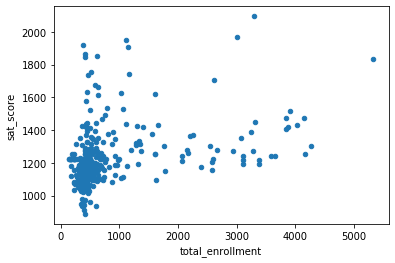

In [57]:
combined.plot.scatter(x = 'total_enrollment', y = 'sat_score')

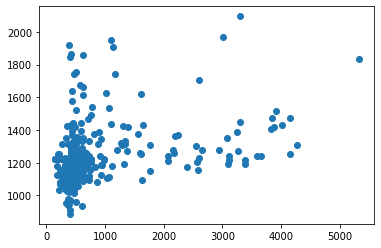

In [58]:
plt.scatter(x= combined.total_enrollment, y = combined.sat_score)

In [59]:
low_enrollment = combined[(combined.total_enrollment < 1000) & (combined.sat_score < 1000)]
low_enrollment['School Name']

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

In [60]:
low_enrollment.shape

(12, 166)

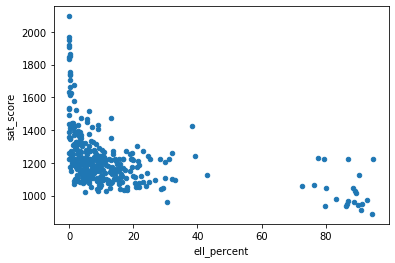

In [61]:
combined.plot.scatter('ell_percent', 'sat_score')

In [62]:
import geopandas
from mpl_toolkits.basemap import Basemap

/home/ning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/home/ning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


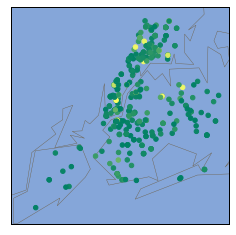

In [63]:
m = Basemap(projection='merc',
           llcrnrlat=40.496044,urcrnrlat=40.915256,llcrnrlon=-74.255735,urcrnrlon=-73.700272,resolution='i')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color = '#6D5F47', linewidth = .4)
m.drawrivers(color = '#6D5F47', linewidth = .4)

longitudes = combined['lon'].tolist()
latitudes = combined['lat'].tolist()
#Basemap.scatter(m, longitudes, latitudes, s = 20, zorder = 2, latlon=True)
m.scatter(longitudes, latitudes, s = 20, zorder = 2, latlon = True, c = combined['ell_percent'], cmap='summer')
# s = 20, size of point, zorder = 2 to plot the points on top of teh rest of the map. latlon=True to indicate lonlat
plt.show()

* Display the percentage of English learners by area
* Aggregate by district, which will enable use to plot ell_percent district-by-district intead school-by-school

In [64]:
districts = combined.groupby('school_dist').agg(np.mean)
districts.reset_index(inplace = True)
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,Total Grads - % of cohort,...,priority08,priority09,priority10,Community Board,Council District,Census Tract,BIN,BBL,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,71.333333,...,0.0,0.0,0.0,3.000000,1.500000,1106.833333,1.004144e+06,1.003302e+09,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,75.453574,...,0.0,0.0,0.0,4.204005,2.963296,1132.479744,1.103862e+06,1.070438e+09,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,74.029937,...,0.0,0.0,0.0,7.500000,6.500000,166.666667,1.034931e+06,1.012833e+09,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,76.257143,...,0.0,0.0,0.0,11.000000,8.000000,2637.000000,1.055874e+06,1.016681e+09,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,75.200881,...,0.0,0.0,0.0,9.428571,8.142857,9372.571429,1.063080e+06,1.019721e+09,40.817077,-73.949251


/home/ning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/home/ning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


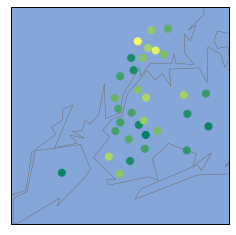

In [65]:
m = Basemap(projection='merc',
           llcrnrlat=40.496044,urcrnrlat=40.915256,llcrnrlon=-74.255735,urcrnrlon=-73.700272,resolution='i')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color = '#6D5F47', linewidth = .4)
m.drawrivers(color = '#6D5F47', linewidth = .4)

longitudes = districts.lon.tolist()
latitudes = districts.lat.tolist()

m.scatter(longitudes, latitudes, s = 50, zorder = 2, latlon = True, 
         c = districts['ell_percent'], cmap = 'summer')
plt.show()

### Plotting survey correlations

In [66]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation
survey_fields.remove('DBN')
survey_fields

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

In [69]:
survey_fields_score = survey_fields + ['sat_score']
corr_survey_score = combined[survey_fields_score].corr()['sat_score']
corr_survey_score

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
sat_score     1.000000
Name: sat_score, dtype: float64

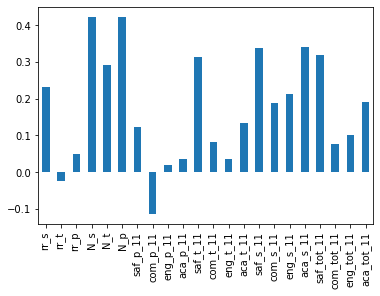

In [70]:
corr_survey_score[:-1].plot.bar()

* Number of student responds, number of parent responds, Number of teach respond are strongly positive correlation with sat_score. Good wish to respond? 
* saf_t_11, saf_s_11, which measures how teachers and students perceive safety at school, correlated highly with sat_score.
### Investigate safety scores

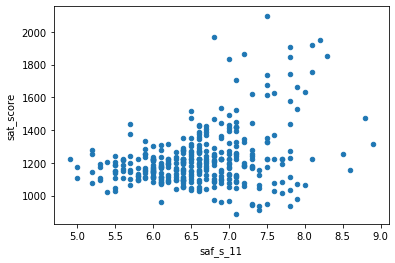

In [71]:
combined.plot.scatter('saf_s_11', 'sat_score')

In [76]:
combined['Council District'].sort_values().unique()

array([ 1.        ,  2.        ,  3.        ,  4.        ,  5.        ,
        6.        ,  7.        ,  8.        ,  9.        , 10.        ,
       11.        , 12.        , 13.        , 14.        , 15.        ,
       16.        , 17.        , 18.        , 19.        , 20.        ,
       21.        , 22.        , 22.23822715, 23.        , 24.        ,
       25.        , 26.        , 27.        , 28.        , 29.        ,
       30.        , 31.        , 32.        , 33.        , 34.        ,
       35.        , 36.        , 37.        , 38.        , 39.        ,
       40.        , 41.        , 42.        , 43.        , 44.        ,
       45.        , 46.        , 47.        , 48.        , 49.        ,
       50.        , 51.        ])

In [78]:
combined['Council District'].value_counts(dropna= False)

33.000000    19
16.000000    18
3.000000     18
17.000000    16
1.000000     16
26.000000    15
8.000000     13
10.000000    11
15.000000    11
12.000000    11
2.000000     11
6.000000     10
11.000000    10
24.000000    10
35.000000    10
37.000000    10
18.000000     9
47.000000     9
34.000000     8
40.000000     8
46.000000     7
9.000000      7
31.000000     7
13.000000     6
42.000000     6
39.000000     5
27.000000     5
36.000000     5
5.000000      5
41.000000     5
32.000000     4
50.000000     4
45.000000     4
23.000000     4
20.000000     4
7.000000      4
28.000000     4
44.000000     3
51.000000     3
4.000000      3
49.000000     3
43.000000     3
25.000000     3
48.000000     3
22.238227     2
19.000000     2
29.000000     2
22.000000     2
14.000000     2
21.000000     1
30.000000     1
38.000000     1
Name: Council District, dtype: int64

In [79]:
combined['district_code'] = combined['Council District'].apply(lambda x : round(x))
combined['district_code'].value_counts()

33    19
3     18
16    18
1     16
17    16
26    15
8     13
2     11
15    11
12    11
10    11
6     10
24    10
11    10
37    10
35    10
18     9
47     9
34     8
40     8
46     7
31     7
9      7
13     6
42     6
36     5
27     5
5      5
39     5
41     5
7      4
45     4
23     4
28     4
50     4
22     4
32     4
20     4
43     3
49     3
4      3
51     3
25     3
44     3
48     3
29     2
14     2
19     2
30     1
38     1
21     1
Name: district_code, dtype: int64

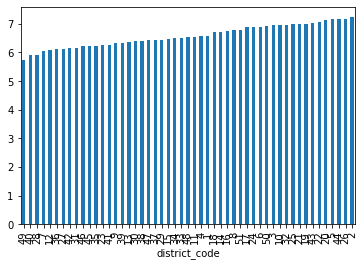

In [83]:
combined.groupby('district_code').agg(np.mean)['saf_s_11'].sort_values().plot.bar()

### Racial and sat_score correlation

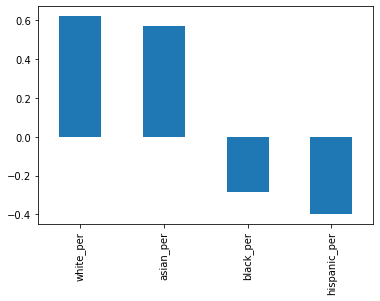

In [84]:
cols_compare = ['sat_score', 'white_per', 'asian_per', 'black_per', 'hispanic_per']
corr_sat = combined[cols_compare].corr()
corr_sat.iloc[1:, :]['sat_score'].plot.bar()

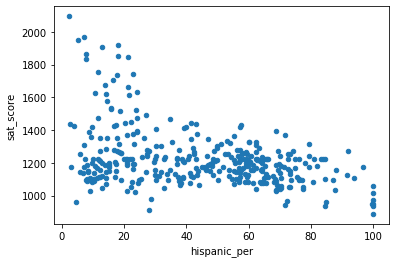

In [86]:
combined.plot(x = 'hispanic_per', y = 'sat_score', kind='scatter')

In [90]:
combined[combined.hispanic_per > 95][['SCHOOL NAME', 'DBN', 'Council District','sat_score']]

,SCHOOL NAME,DBN,Council District,sat_score
44,MANHATTAN BRIDGES HIGH SCHOOL,02M542,3.000000,1058.0
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,06M348,10.000000,1174.0
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,06M552,22.238227,1014.0
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,09X365,14.000000,951.0
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,10X342,11.000000,934.0
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,12X388,18.000000,970.0
253,MULTICULTURAL HIGH SCHOOL,19K583,37.000000,887.0
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,24Q296,25.000000,951.0


In [91]:
combined[(combined.hispanic_per < 10) & (combined.sat_score > 1800)][['SCHOOL NAME', 'DBN', 'Council District', 'sat_score']]

,SCHOOL NAME,DBN,Council District,sat_score
37,STUYVESANT HIGH SCHOOL,02M475,1.0,2096.0
151,BRONX HIGH SCHOOL OF SCIENCE,10X445,11.0,1969.0
187,BROOKLYN TECHNICAL HIGH SCHOOL,13K430,35.0,1833.0
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,28Q687,27.0,1868.0
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,31R605,50.0,1953.0


In [92]:
combined[(combined.female_per > 60) & (combined.sat_score > 1700)][['SCHOOL NAME', 'DBN', 'Council District','sat_score']]

,SCHOOL NAME,DBN,Council District,sat_score
5,BARD HIGH SCHOOL EARLY COLLEGE,01M696,2.0,1856.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,02M416,5.0,1758.0
60,BEACON HIGH SCHOOL,03M479,6.0,1744.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,03M485,6.0,1707.0
302,TOWNSEND HARRIS HIGH SCHOOL,25Q525,24.0,1910.0
